## Evaluate the RBF kernel on the full signal over a range of gap sizes

- Use GPytorch
- Pulsation + noise
- RBF kernel
- Predefined gap timestamps
- Multiple gap sizes

In [1]:
import os
import sys
import math
%load_ext autoreload
%autoreload 2

import numpy as np
np.random.seed(0)

# Plotting tools
from matplotlib import pyplot as plt
# we use the following for plotting figures in jupyter
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

from astropy.timeseries import LombScargle
import pandas as pd
pd.set_option('precision', 0)
pd.set_option('display.float_format', lambda x: '%.16f' % x)

import torch
import gpytorch

# Start the notebook from the root of the project
if 'notebooks' in os.getcwd():
    os.chdir(os.path.dirname(os.getcwd()))
    if os.getcwd().endswith('notebooks'):
        os.chdir(os.path.dirname(os.getcwd()))

 # Local imports (i.e., my code) from the src folder
sys.path.insert(0, os.path.join(os.getcwd(), 'src'))

from plot_helpers import *
plotter = PlotUtilGPyTorch()

Read the first time series

In [2]:
# Make the notebook use the whole screen width
from IPython.display import display, HTML

display(HTML(data="""
<style>
    div#notebook-container    { width: 95%; }
    div#menubar-container     { width: 65%; }
    div#maintoolbar-container { width: 99%; }
</style>
"""))

In [3]:
df = pd.read_csv("./data/sim_pulse.lc",sep=' ', header = None, names=['Time', 'Lc'], index_col=False, float_precision='round_trip')
df.dtypes

Time    float64
Lc      float64
dtype: object

In [4]:
X, Y = df['Time'].tolist(), df['Lc'].tolist()
X, Y = np.array(X), np.array(Y)

Zoomed in on the first N observations

# 1. Exploratory
Plot the data

In [5]:
# 11300 is the complete first envelope
N_part=11300

In [6]:
X_part=X[:N_part]
Y_part=Y[:N_part]

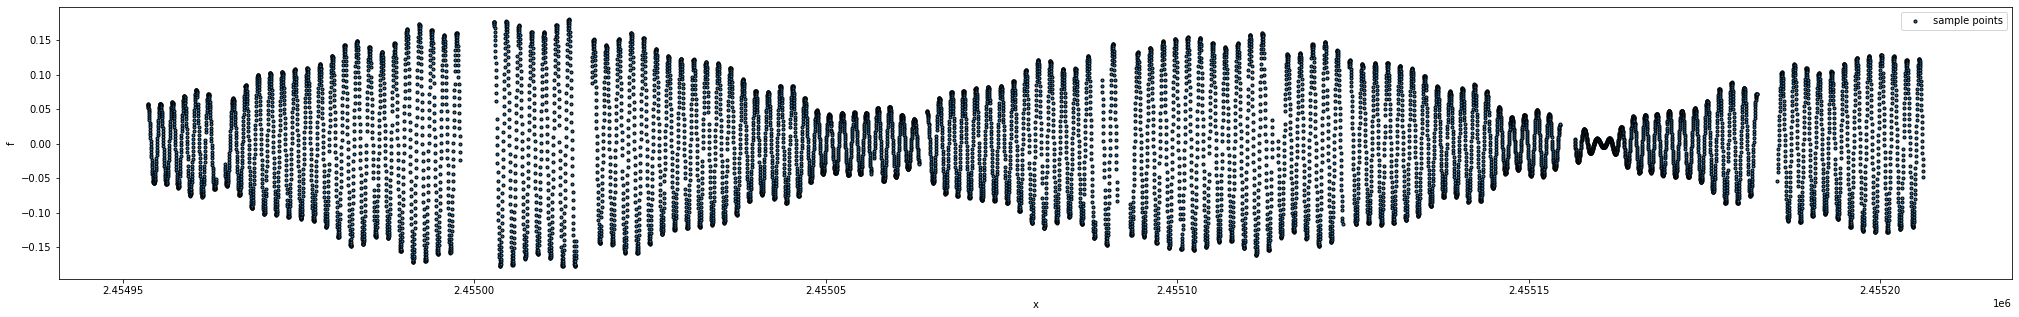

In [7]:
plotter.plot_data(X_part, Y_part)

# 2. Processing


Fit a simple smoothing kernel to the signal

In [8]:
# normalize the data
mean, std = Y_part.mean(),Y_part.std()
Y_part = (Y_part - mean) / std

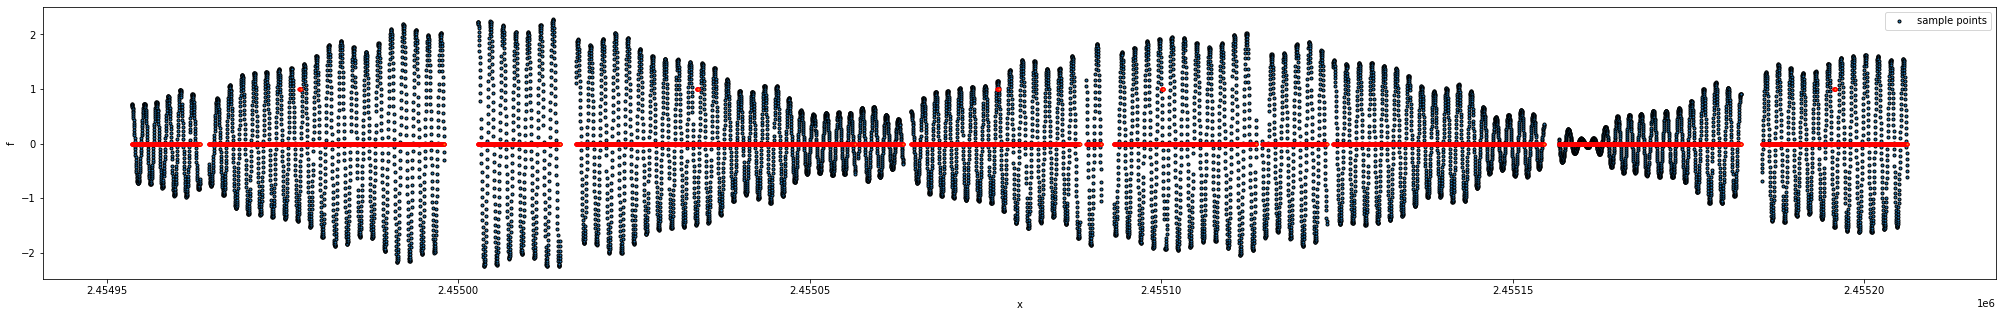

In [9]:
# Introduce gaps in the data
gap_idcs = [1100, 3500, 5500, 6500, 10800]
gap_size = 10

# Define the masks where will introduce the gaps
Y_mask = np.zeros(X_part.shape)
for idx in gap_idcs:
    Y_mask[int(idx-gap_size/2):int(idx+gap_size/2)] = 1

# Now store the timestamps of this gaps for our fitting procedure
X_gaps = X_part[Y_mask==1]

# And remove the observations at the gaps from X and Y
X_without_gaps = X_part[Y_mask==0]
Y_without_gaps = Y_part[Y_mask==0]

plotter.plot_data(X_part, Y_part, X_part, Y_mask)
plotter.plot_data(X_part, Y_part, X_without_gaps, Y_without_gaps)

In [10]:
X_without_gaps=torch.tensor(X_without_gaps)
Y_without_gaps=torch.tensor(Y_without_gaps)
X_gaps=torch.tensor(X_gaps)
X_part=torch.tensor(X_part)
Y_part=torch.tensor(Y_part)

In [11]:
from gpytorch.priors import NormalPrior

# We will use the simplest form of GP model, exact inference
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ZeroMean()
        # Periodic kernel for the Pulsations
        self.pulse_kernel = gpytorch.kernels.PeriodicKernel()
        self.pulse_kernel.period_length = 1.77
        self.pulse_kernel.lengthscale = 0.001
        # Periodic kernel for the Gaps
        self.pulse_kernel2 = gpytorch.kernels.PeriodicKernel()
        self.pulse_kernel2.period_length = 1.77 * 3
        self.pulse_kernel2.lengthscale = 0.001
        # RBF kernel for the uncorrelated noise
        self.noise_kernel = gpytorch.kernels.RBFKernel()
        
        # No solution yet for the non-stationary instrumentation noise
        self.covar_module = gpytorch.kernels.AdditiveKernel(
            gpytorch.kernels.ScaleKernel(self.pulse_kernel),
            gpytorch.kernels.ScaleKernel(self.pulse_kernel2),
            gpytorch.kernels.ScaleKernel(self.noise_kernel),
        )

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# initialize likelihood and model
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = ExactGPModel(X_without_gaps, Y_without_gaps, likelihood)

# As we are using float64 data, we need to convert our model to double
_ = model.double()
_ = likelihood.double()

In [12]:
training_iter = 50

# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer on a subset of the hyperparameters
all_params = set(model.parameters())
final_params = all_params # list(all_params - {model.covar_module.kernels[0].base_kernel.raw_period_length})
optimizer = torch.optim.Adam(final_params, lr=0.15)

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

for i in range(training_iter):
    # Zero gradients from previous iteration
    optimizer.zero_grad()
    # Output from model
    output = model(X_without_gaps)
    # Calc loss and backprop gradients
    loss = -mll(output, Y_without_gaps)
    loss.backward()
    print('Iter %d/%d - Loss: %.3f   Period length: %.3f    noise: %.3f' % (
        i + 1, training_iter, loss.item(),
        0,  # model.covar_module.kernels[0].base_kernel.period_length.item(),
        model.likelihood.noise.item()
    ))
    optimizer.step()

Iter 1/50 - Loss: 0.946   Period length: 0.000    noise: 0.693
Iter 2/50 - Loss: 0.876   Period length: 0.000    noise: 0.621
Iter 3/50 - Loss: 0.796   Period length: 0.000    noise: 0.554
Iter 4/50 - Loss: 0.725   Period length: 0.000    noise: 0.493
Iter 5/50 - Loss: 0.664   Period length: 0.000    noise: 0.437
Iter 6/50 - Loss: 0.605   Period length: 0.000    noise: 0.386
Iter 7/50 - Loss: 0.544   Period length: 0.000    noise: 0.340
Iter 8/50 - Loss: 0.483   Period length: 0.000    noise: 0.299
Iter 9/50 - Loss: 0.420   Period length: 0.000    noise: 0.262
Iter 10/50 - Loss: 0.358   Period length: 0.000    noise: 0.229
Iter 11/50 - Loss: 0.289   Period length: 0.000    noise: 0.199
Iter 12/50 - Loss: 0.223   Period length: 0.000    noise: 0.173
Iter 13/50 - Loss: 0.156   Period length: 0.000    noise: 0.150
Iter 14/50 - Loss: 0.082   Period length: 0.000    noise: 0.130
Iter 15/50 - Loss: 0.017   Period length: 0.000    noise: 0.113
Iter 16/50 - Loss: -0.062   Period length: 0.000 

In [22]:
# Get into evaluation (predictive posterior) mode
model.eval()
likelihood.eval()
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    Y_pred_gaps = likelihood(model(X_part))

In [24]:
plotter.plot_data(X_part.cpu(), Y_part.cpu(), X_part.cpu(), Y_pred_gaps.mean.cpu())

In [29]:
# Calculate the residuals on the original X positions!
residuals = Y_part-Y_pred_gaps.mean.cpu()
plotter.plot_data(X_part, Y_part, X_part, residuals)

# Correlation between the original data and the fitted data

In [26]:
ts_orig = pd.DataFrame()
ts_orig['signal'] = Y_part
ts_fitted = pd.DataFrame()
ts_fitted['signal'] = Y_pred_gaps.mean.cpu()

In [27]:
ts_orig.corrwith(ts_fitted)

signal   0.9982322204464007
dtype: float64